In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate

from adm1.ode import ADM1_ODE
from adm1.dae import DAESolve  # pure DAE solver
from adm1.params import *
from adm1.solver import simulate
import scipy

499.995 0.0049999999999954525 50.0
V_liq 10000
V_gas 880.0
V_ad 10880.0

State Input Values:
S_su_in: 0.001
S_aa_in: 0.001
S_fa_in: 0.001
S_va_in: 0.001
S_bu_in: 0.001
S_pro_in: 0.001
S_ac_in: 0.001
S_h2_in: 1e-08
S_ch4_in: 1e-05
S_IC_in: 0.04
S_IN_in: 0.01
S_I_in: 0.02
X_xc1_in: 0.0
X_ch1_in: 20.056799429999998
X_pr1_in: 12.67387326
X_li1_in: 9.99690003
X_xc2_in: 0.0
X_ch2_in: 0.002053936799990653
X_pr2_in: 0.00047838527999782284
X_li2_in: 6.759791999969236e-05
X_su_in: 0.0
X_aa_in: 0.0
X_fa_in: 0.0
X_c4_in: 0.0
X_pro_in: 0.0
X_ac_in: 0.0
X_h2_in: 0.0
X_I_in: 25.0
S_cation_in: 0.04
S_anion_in: 0.02
State Zero Values:
S_su: 1e-05
S_aa: 1e-05
S_fa: 1e-05
S_va: 1e-05
S_bu: 1e-05
S_pro: 1e-05
S_ac: 1e-05
S_h2: 1e-08
S_ch4: 1e-05
S_IC: 0.04
S_IN: 0.01
S_I: 0.02
X_xc1: 6.2499375e-07
X_ch1: 1.5624843750000003e-06
X_pr1: 6.249937500000001e-06
X_li1: 1.5624843750000003e-06
X_xc2: 0.0
X_ch2: 7.894179486649867e-11
X_pr2: 1.8391512794263297e-11
X_li2: 2.6666923387829425e-12
X_su: 1.41
X_aa: 0.75


In [2]:
# Initiate the cache data frame for storing simulation results
simulate_results = pd.DataFrame([state_zero])
columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "S_cation", "S_anion", "pH", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2"]
simulate_results.columns = columns

# Initiate cache data frame for storing gasflow values
initflow = {'p_gas_h2': [0],'p_gas_ch4': [0],'p_gas_co2': [0],'p_gas': [0],'q_gas': [0], 'q_ch4': [0], 'total_ch4': [0],'p_gas_ch4/p_gas': [0],'p_gas_co2/p_gas': [0], 'ch4_yield':[0], 'co2_yield':[0] }
gasflow = pd.DataFrame(initflow)
total_ch4 = 0

# Initiate cache data frame for storing inhibition values
initflow = {'I_5': [0],'I_7': [0],'I_8': [0],'I_10': [0],'I_12': [0],'I_pH_aa': [0],'I_pH_h2': [0],'I_IN_lim': [0],'I_h2_fa': [0],'I_h2_c4': [0], 'I_h2_pro': [0]}
inhibition = pd.DataFrame(initflow)

# Initiate cache data frame for storing ions values
initflow = {'S_cation': [0],'S_anion': [0],'S_H_ion': [0],'S_va_ion': [0],'S_bu_ion': [0],'S_pro_ion': [0],'S_ac_ion': [0],'S_hco3_ion': [0],'S_nh4_ion': [0]}
ions = pd.DataFrame(initflow)

In [3]:
solvermethod = 'DOP853'
# solvermethod = 'BDF'

for u in t[1:]:
    n += 1

    state_input = [S_su_in, S_aa_in, S_fa_in, S_va_in, S_bu_in, S_pro_in, S_ac_in, S_h2_in, S_ch4_in, S_IC_in, S_IN_in, S_I_in,
                   X_xc1_in, X_ch1_in, X_pr1_in, X_li1_in, X_xc2_in, X_ch2_in, X_pr2_in, X_li2_in,
                   X_su_in, X_aa_in, X_fa_in, X_c4_in, X_pro_in, X_ac_in, X_h2_in, X_I_in, S_cation_in, S_anion_in]

    # Span for next time step
    tstep = [t0, u]

    print('Time step:', n, ' Time (days):', u)
    print('S_su =', S_su, '\n', 'S_aa =', S_aa, '\n', 'S_fa =', S_fa, '\n', 'S_h2 =', S_h2)

    # Build current state vector (y0)
    current_state = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I,
                     X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2,
                     X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion,
                     S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion,
                     S_gas_h2, S_gas_ch4, S_gas_co2]

    # ODE integration
    sim = simulate(tstep, current_state, state_input, solvermethod)

    # Unpack solution arrays
    (sim_S_su, sim_S_aa, sim_S_fa, sim_S_va, sim_S_bu, sim_S_pro, sim_S_ac, sim_S_h2, sim_S_ch4, sim_S_IC, sim_S_IN, sim_S_I,
     sim_X_xc1, sim_X_ch1, sim_X_pr1, sim_X_li1, sim_X_xc2, sim_X_ch2, sim_X_pr2, sim_X_li2,
     sim_X_su, sim_X_aa, sim_X_fa, sim_X_c4, sim_X_pro, sim_X_ac, sim_X_h2, sim_X_I, sim_S_cation, sim_S_anion,
     sim_S_H_ion, sim_S_va_ion, sim_S_bu_ion, sim_S_pro_ion, sim_S_ac_ion, sim_S_hco3_ion, sim_S_co2, sim_S_nh3, sim_S_nh4_ion,
     sim_S_gas_h2, sim_S_gas_ch4, sim_S_gas_co2) = sim

    # Take last values
    S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, \
    X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, \
    X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, \
    S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, \
    S_gas_h2, S_gas_ch4, S_gas_co2 = \
        sim_S_su[-1], sim_S_aa[-1], sim_S_fa[-1], sim_S_va[-1], sim_S_bu[-1], sim_S_pro[-1], sim_S_ac[-1], sim_S_h2[-1], sim_S_ch4[-1], sim_S_IC[-1], sim_S_IN[-1], sim_S_I[-1], \
        sim_X_xc1[-1], sim_X_ch1[-1], sim_X_pr1[-1], sim_X_li1[-1], sim_X_xc2[-1], sim_X_ch2[-1], sim_X_pr2[-1], sim_X_li2[-1], \
        sim_X_su[-1], sim_X_aa[-1], sim_X_fa[-1], sim_X_c4[-1], sim_X_pro[-1], sim_X_ac[-1], sim_X_h2[-1], sim_X_I[-1], sim_S_cation[-1], sim_S_anion[-1], \
        sim_S_H_ion[-1], sim_S_va_ion[-1], sim_S_bu_ion[-1], sim_S_pro_ion[-1], sim_S_ac_ion[-1], sim_S_hco3_ion[-1], sim_S_co2[-1], sim_S_nh3[-1], sim_S_nh4_ion[-1], \
        sim_S_gas_h2[-1], sim_S_gas_ch4[-1], sim_S_gas_co2[-1]

    # Algebraic update (pure DAE) - pass state, receive corrected state & pH
    state_for_dae = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I,
                     X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2,
                     X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion,
                     S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion,
                     S_gas_h2, S_gas_ch4, S_gas_co2]
    
    
    new_state, pH_value = DAESolve(state_for_dae)

    # Overwrite updated components from new_state (others unchanged)
    S_h2 = new_state[7]
    S_H_ion = new_state[30]
    S_va_ion = new_state[31]
    S_bu_ion = new_state[32]
    S_pro_ion = new_state[33]
    S_ac_ion = new_state[34]
    S_hco3_ion = new_state[35]
    S_co2 = new_state[36]
    S_nh3 = new_state[37]
    S_nh4_ion = new_state[38]
    # pH_value available if needed for direct storage/inhibition calcs

    prevS_H_ion = S_H_ion

    #I_pH_aa =  ((K_pH_aa ** nn_aa) / (S_H_ion ** nn_aa + K_pH_aa ** nn_aa))
    #I_pH_ac =  ((K_pH_ac ** n_ac) / (S_H_ion ** n_ac + K_pH_ac ** n_ac))
    #I_pH_h2 =  ((K_pH_h2 ** n_h2) / (S_H_ion ** n_h2 + K_pH_h2 ** n_h2))
    #I_IN_lim =  (1 / (1 + (K_S_IN / S_IN)))
    #I_h2_fa =  (1 / (1 + (S_h2 / K_I_h2_fa)))
    #I_h2_c4 =  (1 / (1 + (S_h2 / K_I_h2_c4)))
    #I_h2_pro =  (1 / (1 + (S_h2 / K_I_h2_pro)))
    #I_nh3 =  (1 / (1 + (S_nh3 / K_I_nh3)))

    I_pH_aa = 1
    I_pH_ac = 1
    I_pH_h2 = 1
    I_IN_lim = 1
    I_h2_fa = 1
    I_h2_c4 = 1
    I_h2_pro = 1
    I_nh3 = 1

    I_5 = I_pH_aa * I_IN_lim
    I_6 = I_5
    I_7 = I_pH_aa * I_IN_lim * I_h2_fa
    I_8 = I_pH_aa * I_IN_lim * I_h2_c4
    I_9 = I_8
    I_10 = I_pH_aa * I_IN_lim * I_h2_pro
    I_12 = I_pH_h2 * I_IN_lim

    inhibittemp = {'I_5': I_5,'I_7': I_7,'I_8': I_8,'I_10': I_10,'I_12': I_12, 'I_pH_aa': I_pH_aa,'I_pH_ac': I_pH_ac,'I_pH_h2': I_pH_h2, 'I_IN_lim': I_IN_lim,'I_h2_fa': I_h2_fa,'I_h2_c4': I_h2_c4,'I_h2_pro': I_h2_pro,'I_nh3': I_nh3}
    inhibition = pd.concat([inhibition, pd.DataFrame([inhibittemp])], ignore_index=True)

    ################

    S_nh4_ion =  (S_IN - S_nh3)
    S_co2 =  (S_IC - S_hco3_ion)
    #pH = - np.log10(S_H_ion)

    # Algebraic equations 

    p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
    p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
    p_gas_co2 =  (S_gas_co2 * R * T_op)
    
    Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
    Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
    Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
    p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
    q_gas =  (k_p * (p_gas- p_atm))
    
    #q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)
    
    if q_gas < 0:    
     q_gas = 0
    
    q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
    q_co2 = q_gas * (p_gas_co2/p_gas) # co2 flow
    q_h2 = q_gas * (p_gas_h2/p_gas) # h2 flow

    if q_ch4 < 0:
     q_ch4 = 0

    total_ch4 = total_ch4 + q_ch4 

    flowtemp = {'p_gas_h2': p_gas_h2,'p_gas_ch4': p_gas_ch4,'p_gas_co2': p_gas_co2,'p_gas': p_gas,'q_gas': q_gas, 'q_ch4': q_ch4, 'total_ch4': total_ch4, 'p_gas_ch4/p_gas': p_gas_ch4/p_gas,'p_gas_co2/p_gas': p_gas_co2/p_gas, 'ch4_yield':q_ch4/VS_in, 'co2_yield':q_co2/VS_in, 'h2_yield':q_h2/VS_in}
    gasflow = pd.concat([gasflow, pd.DataFrame([flowtemp])], ignore_index=True)

    total_ch4 = total_ch4 + q_ch4     
    
    ############
       
    ionstemp = {'S_cation': S_cation,'S_anion': S_anion,'S_H_ion': S_H_ion,'S_va_ion': S_va_ion,'S_bu_ion': S_bu_ion,'S_pro_ion': S_pro_ion,'S_ac_ion': S_ac_ion,'S_hco3_ion': S_hco3_ion,'S_nh4_ion': S_nh4_ion}
    ions = pd.concat([ions, pd.DataFrame([ionstemp])], ignore_index=True)

    ##############

    # Rebuild and append state (store pH later)
    state_zero = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, \
                  X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, \
                  X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, \
                  S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, \
                  S_gas_h2, S_gas_ch4, S_gas_co2]

    dfstate_zero = pd.DataFrame([state_zero], columns=columns)
    simulate_results = pd.concat([simulate_results, dfstate_zero], ignore_index=True)
    t0 = u

Time step: 1  Time (days): 0.041701417848206836
S_su = 1e-05 
 S_aa = 1e-05 
 S_fa = 1e-05 
 S_h2 = 1e-08
Time step: 2  Time (days): 0.08340283569641367
S_su = 0.0031377037901836567 
 S_aa = 0.0014525835604334493 
 S_fa = 0.003358553618653794 
 S_h2 = 4.180631340162192e-08
Time step: 3  Time (days): 0.12510425354462051
S_su = 0.006271361821234374 
 S_aa = 0.002726370518161356 
 S_fa = 0.010982469136335998 
 S_h2 = 9.066851000278842e-08
Time step: 4  Time (days): 0.16680567139282734
S_su = 0.008421219079725546 
 S_aa = 0.003590465707326356 
 S_fa = 0.02045391742729772 
 S_h2 = 1.298120129560727e-07
Time step: 5  Time (days): 0.20850708924103417
S_su = 0.009875254010168852 
 S_aa = 0.004177773687112237 
 S_fa = 0.03042877493344598 
 S_h2 = 1.5999638287571182e-07
Time step: 6  Time (days): 0.25020850708924103
S_su = 0.010860999909430622 
 S_aa = 0.004580218228474613 
 S_fa = 0.04019528392622636 
 S_h2 = 1.830045451612367e-07
Time step: 7  Time (days): 0.29190992493744783
S_su = 0.01153397

In [4]:
p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
p_gas_co2 =  (S_gas_co2 * R * T_op)
Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
q_gas =  (k_p * (p_gas- p_atm))

#q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)

if q_gas < 0:    
  q_gas = 0

q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
if q_ch4 < 0:
  q_ch4 = 0

In [5]:
phlogarray = -1 * np.log10(simulate_results['pH'])
simulate_results['pH'] = phlogarray

In [6]:


print ('S_su =', S_su, "\n",
         'S_aa =', S_aa, "\n",
         'S_fa =', S_fa, "\n",
         'S_va =', S_va, "\n",
         'S_bu =', S_bu, "\n",
         'S_pro =', S_pro, "\n",
         'S_ac =', S_ac, "\n",
         'S_h2 =', S_h2, "\n",
         'S_ch4 =', S_ch4, "\n",
         'S_IC =', S_IC, "\n",
         'S_IN =', S_IN, "\n",
         'S_I =', S_I, "\n",
         'X_xc1 =', X_xc1, "\n",
         'X_ch1 =', X_ch1, "\n",
         'X_pr1 =', X_pr1, "\n",
         'X_li1 =', X_li1, "\n",
         'X_xc2 =', X_xc2, "\n",
         'X_ch2 =', X_ch2, "\n",
         'X_pr2 =', X_pr2, "\n",
         'X_li2 =', X_li2, "\n",
         'X_su =', X_su, "\n",
         'X_aa =', X_aa, "\n",
         'X_fa =', X_fa, "\n",
         'X_c4 =', X_c4, "\n",
         'X_pro =', X_pro, "\n",
         'X_ac =', X_ac, "\n",
         'X_h2 =', X_h2, "\n",
         'X_I =', X_I, "\n",
         'S_cation =', S_cation,"\n", 
         'S_anion =', S_anion, "\n",
         'S_H_ion =', S_H_ion, "\n",
         'S_va_ion =', S_va_ion, "\n",
         'S_bu_ion =', S_bu_ion, "\n",
         'S_pro_ion =', S_pro_ion, "\n",
         'S_ac_ion =', S_ac_ion, "\n",
         'S_hco3_ion =', S_hco3_ion, "\n",
         'S_co2 =', S_co2, "\n",
         'S_nh3 =', S_nh3, "\n",
         'S_nh4_ion =', S_nh4_ion,"\n", 
         'S_gas_h2 =', S_gas_h2, "\n",
         'S_gas_ch4 =', S_gas_ch4, "\n",
         'S_gas_co2 =', S_gas_co2, "\n",

         'p_gas_h2 =', p_gas_h2, "\n",
         'p_gas_ch4 =', p_gas_ch4, "\n",
         'p_gas_co2 =', p_gas_co2, "\n",
         'p_gas =', p_gas,"\n", 
         'q_gas =', q_gas, "\n",
         'q_ch4 =', q_ch4, "\n",
         'biomethane yield =', q_ch4/VS_in, "\n",
         'biomethane yield2 =', q_ch4/V_ad)

S_su = 0.011757765729770414 
 S_aa = 0.005205554581319866 
 S_fa = 0.09146214405042238 
 S_va = 0.009647080695328191 
 S_bu = 0.013838554898589569 
 S_pro = 0.005794565365280526 
 S_ac = 0.011641809065536947 
 S_h2 = 2.3521274129733767e-07 
 S_ch4 = 0.06031508649877653 
 S_IC = 0.10750558077819905 
 S_IN = 0.07562139361200339 
 S_I = 0.4712246234431292 
 X_xc1 = 0.22606595602144952 
 X_ch1 = 0.10226464848769815 
 X_pr1 = 0.06553367251754891 
 X_li1 = 0.05345518608975621 
 X_xc2 = 2.2606821670251594e-06 
 X_ch2 = 1.953444445403614e-05 
 X_pr2 = 1.2654860473038477e-05 
 X_li2 = 2.9142169808215116e-06 
 X_su = 1.521828360978196 
 X_aa = 0.7682326091238981 
 X_fa = 0.4505914472625634 
 X_c4 = 0.3655601967068137 
 X_pro = 0.49812392191245536 
 X_ac = 2.4335671469365416 
 X_h2 = 0.5059743926323979 
 X_I = 25.951700246060607 
 S_cation = 0.04 
 S_anion = 0.02 
 S_H_ion = 7.043718451994659e-08 
 S_va_ion = 0.009598104228706876 
 S_bu_ion = 0.01377445219827575 
 S_pro_ion = 0.005763768358632805

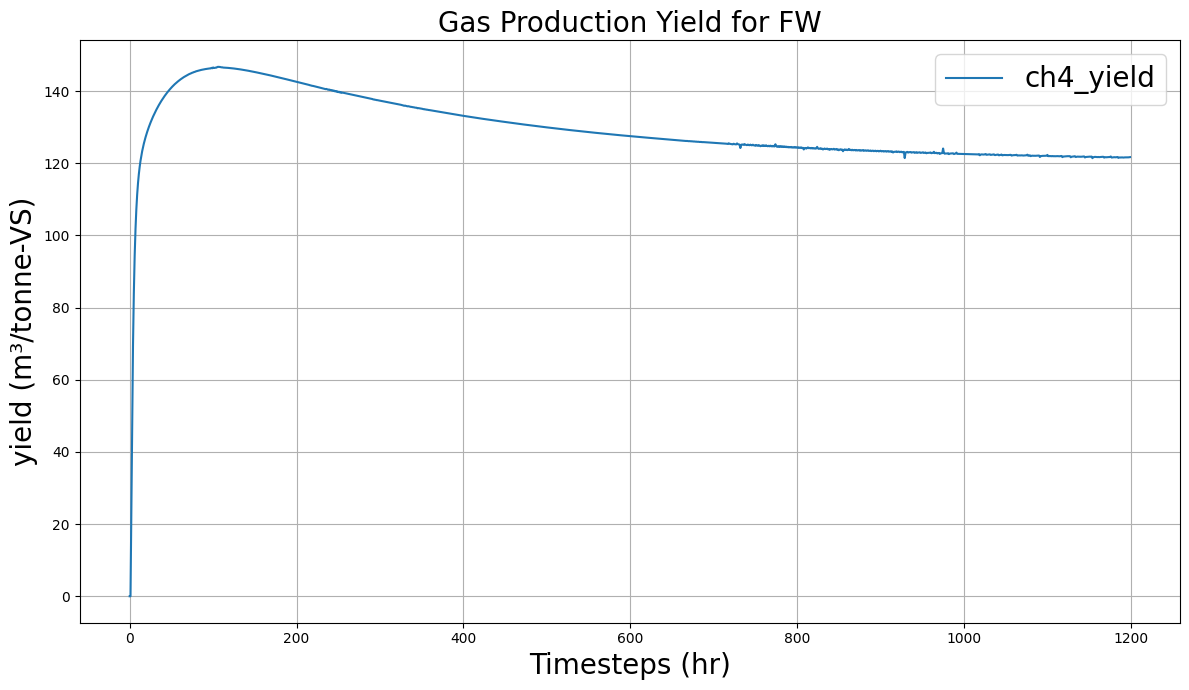

In [7]:
# ─── PLOT GAS FLOWS ──────────────────────────────────────────────────────────────

# If you have a time array t that you looped over, make sure it's in gasflow:
# gasflow['time'] = t   # uncomment or adjust if needed

plt.figure(figsize=(12, 7))

#plt.plot(gasflow['q_gas'],  label='q_gas (Total Gas Flow)')
plt.plot(gasflow['ch4_yield'],  label='ch4_yield')
#plt.plot(gasflow['co2_yield'],  label='co2_yield')
#plt.plot(gasflow['h2_yield'],  label='h2_yield')

plt.xlabel('Timesteps (hr)', fontsize=20)
plt.ylabel('yield (m³/tonne-VS)', fontsize=20)
plt.title('Gas Production Yield for FW', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()
# ──────────────